In [1]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCHDYNAMO_VERBOSE'] = "1"

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

import numpy as np
import random
import math
from pathlib import Path
from fastai.vision import *
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import RichProgressBar, ModelCheckpoint, EarlyStopping, LearningRateMonitor, RichModelSummary
from torchmetrics.text import CharErrorRate

import cv2
from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils
from PIL import  Image
from matplotlib import pyplot as plt
import logging
from logging.config import fileConfig
import sys
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import json

# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
fileConfig("logging.ini")
logger = logging.getLogger("trainer")
torch.set_float32_matmul_precision('medium')
torch.backends.cudnn.benchmark = True
# logger.setLevel(logging.DEBUG)

In [2]:
# Crop images from the via json
# def crop_images_from_via_json(via_json, image_dir, output_dir):
#     with open(via_json) as f:
#         via_json = json.load(f)
    
#     for image_name, image_info in enumerate(via_json.values(), start=1):
#         image_path = os.path.join(image_dir, image_name)

        



In [3]:
ROOT_DIR = Path("dataset/odometer")
TRAIN_DIR = ROOT_DIR / "train"
TEST_DIR = ROOT_DIR / "test"

# HF_MODEL_NAME = "microsoft/trocr-large-stage1"
# HF_MODEL_NAME = "microsoft/trocr-large-printed"
# HF_MODEL_NAME = "microsoft/trocr-large-handwritten"
HF_MODEL_NAME = "microsoft/trocr-small-printed"

processor = TrOCRProcessor.from_pretrained(HF_MODEL_NAME)
# tokenizer = processor.tokenizer



class OdometerDataset(Dataset):
    def __init__(self, root_dir, max_length=10, transforms=None, hf_model_name: str=None):
        self.root_dir = root_dir
        self.max_length = max_length
        self.transforms = transforms
        self.processor = TrOCRProcessor.from_pretrained(hf_model_name)
        self.image_paths = list(sorted(self.root_dir.glob("**/*.jpg")))
        self.text_paths = list(sorted(self.root_dir.glob("**/*.txt")))

    

    def __len__(self):
        return len(self.image_paths)
    
    def filter_text(self, text):
        # Returns only the digits
        return "".join(filter(str.isdigit, text))
    
    def collate_fn(self, batch):
        pixel_values = torch.stack([item["pixel_values"] for item in batch])
        labels = torch.stack([item["labels"] for item in batch])
        return {
            "pixel_values": pixel_values,
            "labels": labels,
        }
    
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        text_path = image_path.parent / (image_path.stem + ".txt")

        image = Image.open(image_path)
        
        with open(text_path) as f:
            text = f.read()
            text = self.filter_text(text)

        if self.transforms:
            image = self.transforms(image=np.array(image))["image"]
            image = processor(image, return_tensors="pt").pixel_values.squeeze(0)
        else:
            image = processor(image, return_tensors="pt").pixel_values.squeeze(0)

        labels = self.processor.tokenizer(text, return_tensors="pt", padding="max_length", max_length=10).input_ids.squeeze(0)
        labels = [label if label != -100 else self.processor.tokenizer.pad_token_id for label in labels]
        labels = torch.tensor(labels)

        # logger.debug(f"Image: {image.shape}, Labels: {labels.shape}")
        
        return {
            "pixel_values": image,
            "labels": labels,
        }
    

        
        

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [4]:
MAX_EPOCHS = 100
MIN_EPOCHS = 10
BATCH_SIZE = 8
LOG_DIR = "tb_logs/trocr_v2"

NUM_WORKERS = 4

MAX_LENGTH = 10

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

LEARNING_RATES = {
    "encoder": 1e-4,
    "encoder.encoder.pooler": 1e-4,
    "decoder": 1e-4,
    "output_projection": 1e-4
}

transforms = A.Compose([
    A.GaussNoise(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Equalize(p=0.5),
    A.HueSaturationValue(p=0.5),
    # A.Normalize(),
    # ToTensorV2(),
])

train_dataset = OdometerDataset(TRAIN_DIR, transforms=transforms, hf_model_name=HF_MODEL_NAME)
test_dataset = OdometerDataset(TEST_DIR, hf_model_name=HF_MODEL_NAME)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=train_dataset.collate_fn, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=test_dataset.collate_fn, drop_last=False)


STEPS_PER_EPOCH = len(train_loader)/BATCH_SIZE
if type(STEPS_PER_EPOCH) == float:
    STEPS_PER_EPOCH = math.ceil(STEPS_PER_EPOCH)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [5]:
model = VisionEncoderDecoderModel.from_pretrained(HF_MODEL_NAME)

model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.max_length = 10

logger.debug("Compiling model")
optimized_model = torch.compile(model)
# optimized_model = model
optimized_model.to(DEVICE)
model.eval()
logger.debug("Model compiled")

[DEBUG]: Compiling model [/tmp/ipykernel_31303/1946567159.py:8]
[DEBUG]: Model compiled [/tmp/ipykernel_31303/1946567159.py:13]


In [6]:
for batch in test_loader:
    for key, value in batch.items():
        batch[key] = value.to(DEVICE)
    outputs = optimized_model(**batch)
    pred_ids = torch.argmax(nn.functional.softmax(outputs.logits, dim=-1), dim=-1)
    break

In [7]:
outputs.loss, outputs.logits.shape, torch.argmax(nn.functional.softmax(outputs.logits, dim=-1), dim=-1)

(tensor(24.0217, device='cuda:0', grad_fn=<CompiledFunctionBackward>),
 torch.Size([8, 10, 64044]),
 tensor([[  143,   143,     5,     2,  6590,     5,     5,     5,     5,     5],
         [  887,     5,   580,     5,   580,     5,     5,     5,     5,     5],
         [    2,     2,  9753,     2,   331,     2,     2,     2,     2,     2],
         [ 1119,  1119,  1048,  2328,  4608,   182,   182,     5,     5,     5],
         [  887,     5,     2,     2,  1539,   182,   182,     5,     5,     5],
         [49564, 49564,  8248, 49564,     2,   331,     5,     5,     5,     5],
         [  467,   467,   331,     2,     2,  3926,     5,     5,     5,     5],
         [    5,     5,     2,     2,     2,   539,     5,     5,     5,     5]],
        device='cuda:0'))

In [8]:
pred_strs = processor.batch_decode(pred_ids, skip_special_tokens=True)
og_strs = processor.batch_decode(batch["labels"], skip_special_tokens=True)

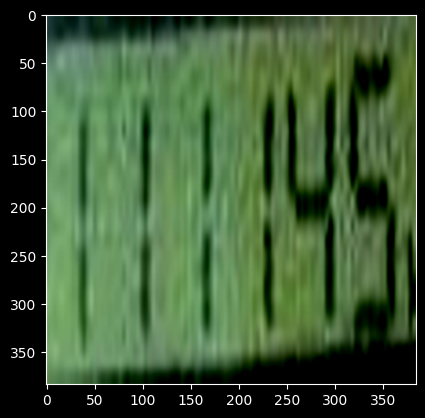

In [9]:
plt.imshow(batch["pixel_values"][1].cpu().numpy().transpose(1, 2, 0))

In [18]:
optimized_model

OptimizedModule(
  (_orig_mod): VisionEncoderDecoderModel(
    (encoder): DeiTModel(
      (embeddings): DeiTEmbeddings(
        (patch_embeddings): DeiTPatchEmbeddings(
          (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): DeiTEncoder(
        (layer): ModuleList(
          (0-11): 12 x DeiTLayer(
            (attention): DeiTAttention(
              (attention): DeiTSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): DeiTSelfOutput(
                (dense): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
          

In [13]:
class TrOCRModelPL(L.LightningModule):
    def __init__(self, model, processor, learning_rates: dict=None, batch_size=8, max_length=10):
        super().__init__()
        self.model = model
        self.processor = processor
        self.cer_train = CharErrorRate()
        self.cer_val = CharErrorRate()

        self.learning_rates = learning_rates
        self.batch_size = batch_size

        self.save_hyperparameters(
            "batch_size",
            "max_length",
            "learning_rates"
        )

        self.automatic_optimization = False

    def training_step(self, batch, batch_idx):
        for key, value in batch.items():
            batch[key] = value.to(self.device)
        labels = batch["labels"].clone()

        optimizer_encoder, optimizer_encoder_pooler, optimizer_decoder, optimizer_output_projection = self.optimizers()

        outputs = self.model(**batch)
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True, logger=True)

        optimizer_encoder.zero_grad()
        optimizer_encoder_pooler.zero_grad()
        optimizer_decoder.zero_grad()
        optimizer_output_projection.zero_grad()

        self.manual_backward(loss)

        optimizer_encoder.step()
        optimizer_encoder_pooler.step()
        optimizer_decoder.step()
        optimizer_output_projection.step()

        lr_scheduler_encoder, lr_scheduler_encoder_pooler, lr_scheduler_decoder, lr_scheduler_output_projection = self.lr_schedulers()

        lr_scheduler_encoder.step()
        lr_scheduler_encoder_pooler.step()
        lr_scheduler_decoder.step()
        lr_scheduler_output_projection.step()

        pred_ids = torch.argmax(nn.functional.softmax(outputs.logits, dim=-1), dim=-1)
        pred_strs = self.processor.batch_decode(pred_ids, skip_special_tokens=True)

        labels[labels == -100] = self.processor.tokenizer.pad_token_id
        labels_strs = self.processor.batch_decode(labels, skip_special_tokens=True)

        self.cer_train(pred_strs, labels_strs)

        self.log("train_cer", self.cer_train, prog_bar=True, logger=True, on_step=True, on_epoch=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        for key, value in batch.items():
            batch[key] = value.to(self.device)
        labels = batch["labels"].clone()

        outputs = self.model(**batch)
        loss = outputs.loss
        self.log("val_loss", loss, prog_bar=True, logger=True)

        pred_ids = torch.argmax(nn.functional.softmax(outputs.logits, dim=-1), dim=-1)
        pred_strs = self.processor.batch_decode(pred_ids, skip_special_tokens=True)

        labels[labels == -100] = self.processor.tokenizer.pad_token_id
        labels_strs = self.processor.batch_decode(labels, skip_special_tokens=True)

        self.cer_val(pred_strs, labels_strs)

        self.log("val_cer", self.cer_val, prog_bar=True, logger=True, on_step=True, on_epoch=True)

        return loss
    
    def configure_optimizers(self):
        optimizer_encoder = optim.SGD(self.model.encoder.encoder.parameters(), lr=self.learning_rates["encoder"])
        optimizer_layer_norm = optim.SGD(self.model.encoder.encoder.layer_norm.parameters(), lr=self.learning_rates["encoder"])
        optimizer_encoder_pooler = optim.SGD(self.model.encoder.encoder.pooler.parameters(), lr=self.learning_rates["encoder.encoder.pooler"])
        optimizer_decoder = optim.SGD(self.model.decoder.model.parameters(), lr=self.learning_rates["decoder"])
        optimizer_output_projection = optim.SGD(self.model.decoder.output_projection.parameters(), lr=self.learning_rates["output_projection"])

        lr_scheduler_encoder = optim.lr_scheduler.OneCycleLR(optimizer_encoder, pct_start=0.0, div_factor=1.5, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, max_lr=self.learning_rates["encoder"], steps_per_epoch=STEPS_PER_EPOCH, epochs=MAX_EPOCHS)
        lr_scheduler_layer_norm = optim.lr_scheduler.OneCycleLR(optimizer_layer_norm, pct_start=0.0, div_factor=1.5, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, max_lr=self.learning_rates["encoder"], steps_per_epoch=STEPS_PER_EPOCH, epochs=MAX_EPOCHS)
        lr_scheduler_encoder_pooler = optim.lr_scheduler.OneCycleLR(optimizer_encoder_pooler,pct_start=0.0, div_factor=1.5, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, max_lr=self.learning_rates["encoder.encoder.pooler"], steps_per_epoch=STEPS_PER_EPOCH, epochs=MAX_EPOCHS)
        lr_scheduler_decoder = optim.lr_scheduler.OneCycleLR(optimizer_decoder,pct_start=0.0, div_factor=1.5, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, max_lr=self.learning_rates["decoder"], steps_per_epoch=STEPS_PER_EPOCH, epochs=MAX_EPOCHS)
        lr_scheduler_output_projection = optim.lr_scheduler.OneCycleLR(optimizer_output_projection,pct_start=0.0, div_factor=1.5, final_div_factor=100000, base_momentum=0.75, max_momentum=0.95, max_lr=self.learning_rates["output_projection"], steps_per_epoch=STEPS_PER_EPOCH, epochs=MAX_EPOCHS)

        lr_scheduler_encoder = {
            "scheduler": lr_scheduler_encoder,
            "interval": "step",
            "frequency": 1
        }
        lr_scheduler_layer_norm = {
            "scheduler": lr_scheduler_layer_norm,
            "interval": "step",
            "frequency": 1
        }
        lr_scheduler_encoder_pooler = {
            "scheduler": lr_scheduler_encoder_pooler,
            "interval": "step",
            "frequency": 1
        }
        lr_scheduler_decoder = {
            "scheduler": lr_scheduler_decoder,
            "interval": "step",
            "frequency": 1
        }
        lr_scheduler_output_projection = {
            "scheduler": lr_scheduler_output_projection,
            "interval": "step",
            "frequency": 1
        }

        return [optimizer_encoder, optimizer_encoder_pooler, optimizer_decoder, optimizer_output_projection], [lr_scheduler_encoder, lr_scheduler_encoder_pooler, lr_scheduler_decoder, lr_scheduler_output_projection]
    
    def train_dataloader(self):
        return train_loader
    
    def val_dataloader(self):
        return test_loader

In [16]:
trainer_model = TrOCRModelPL(optimized_model, processor, learning_rates=LEARNING_RATES, batch_size=BATCH_SIZE, max_length=MAX_LENGTH)
logger.info("TrOCRModelPL created")

logger.info("Creating callbacks")
callbacks = [
    RichModelSummary(max_depth=2),
    RichProgressBar(),
    ModelCheckpoint(
        monitor="val_loss", 
        mode="min",
        save_top_k=3,
        filename="odometer-{epoch:02d}-{val_loss:.2f}",
        ),
    ModelCheckpoint(
        monitor="val_cer", 
        mode="min",
        save_top_k=1,
        filename="odometer-{epoch:02d}-{val_cer:.4f}-cer{val_loss:.4f}",
        ),
]

tb_logger = TensorBoardLogger(LOG_DIR, name="trocr_v2")

trainer = L.Trainer(
    accelerator="gpu",
    max_epochs=MAX_EPOCHS,
    min_epochs=MIN_EPOCHS,
    callbacks=callbacks,
    logger=tb_logger,

    precision="16-true",
    enable_checkpointing=True
)

logger.info("Trainer created")

[INFO]: TrOCRModelPL created [/tmp/ipykernel_31303/3058934534.py:2]
[INFO]: Creating callbacks [/tmp/ipykernel_31303/3058934534.py:4]
[INFO]: Trainer created [/tmp/ipykernel_31303/3058934534.py:35]


In [17]:
trainer.fit(trainer_model)

AttributeError: 'DeiTEncoder' object has no attribute 'pooler'